<style>
  .custom-title {
    font-size: 48px;
    font-weight: bold;
    color: #007acc; /* You can change the color to your preference */
    margin-bottom: 10px;
  }
</style>

<div class="custom-title">Extra for Enthusiasts! : Create your own Dataset</div>


<p>For context, ideally we would want a dataset with a "review" column with sentences that have decent length and minimal grammatical errors, and a "rating" dataset to represent numerical customer rating. The best that I was able to find was this hotel dataset with a great "review" column, but with a bad "rating" column. The goal here is to generate our own rating from what we have on the dataset, using ML.</p>

<style>
  .custom-title {
    font-size: 24px;
    font-weight: bold;
    color: #007acc; /* You can change the color to your preference */
    margin-bottom: 10px;
  }

  .custom-subsection {
    font-size: 18px;
    font-weight: bold;
    color: #009688; /* You can change the color to your preference */
    margin-top: 20px;
  }
</style>

## <span class="custom-subsection">Imports</span>
<p>pandas : for data wrangling</p>
<p>sklearn : ML, Clustering, Dimension Reduction </p>
<p>matplotlib : visualization</p>

In [27]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [28]:
df = pd.read_csv("data/pre_clean_hotel.csv")
df.head(3)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968


In [29]:
df.shape

# (515738, 17)

(515738, 17)

<p>Given the huge size, you will most likely encounter an error here if you simply try to run this. Let's pick out some hotels, and shrink the dataset to around a few thousand.</p>

In [30]:
df['Hotel_Name'].value_counts()

Hotel_Name
Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3578
DoubleTree by Hilton Hotel London Tower of London    3212
                                                     ... 
Ibis Styles Milano Palmanova                           12
Hotel Eitlj rg                                         12
Hotel Wagner                                           10
Mercure Paris Porte d Orleans                          10
Hotel Gallitzinberg                                     8
Name: count, Length: 1492, dtype: int64

In [31]:
selected_hotels = [
    'Britannia International Hotel Canary Wharf',
    'Strand Palace Hotel',
    'Park Plaza Westminster Bridge London'
]

df = df[df['Hotel_Name'].isin(selected_hotels)]


<p>Concatenate the reviews to that we will only have to call the API on one column later. Comprehend would be the one to decide which is the more powerful review (positive or negative).</p>

In [32]:
concatenate_columns = lambda row: row['Negative_Review'] + '. ' + row['Positive_Review']

# Apply the lambda function to create a new column
df['concatenated'] = df.apply(concatenate_columns, axis=1)

In [33]:
columns_to_save = ['concatenated', 'Average_Score']
clean_df = df[columns_to_save]


In [34]:
clean_df

,concatenated,Average_Score
63942,The car park was small and unpleasant People ...,7.1
63943,We weren t told that the only spa facility op...,7.1
63944,I asked how far the O2 was and got told a 7 m...,7.1
63945,Hot stuffy room air con not working properly ...,7.1
63946,Although the price seems like it is cheap you...,7.1
...,...,...
508191,No Negative. Our family apartment room was te...,8.7
508192,No Negative. Great location and overall fanta...,8.7
508193,The staff were not approacable. Location,8.7
508194,Hotel location Best staff Facilities Cleaning...,8.7


In [35]:
# At this point we can already get rid of the original df, so let's overwrite with a new assignment

df = clean_df.rename(columns={'Average_Score': 'rating', 'concatenated' : 'review'} )
df.reset_index()
df

,review,rating
63942,The car park was small and unpleasant People ...,7.1
63943,We weren t told that the only spa facility op...,7.1
63944,I asked how far the O2 was and got told a 7 m...,7.1
63945,Hot stuffy room air con not working properly ...,7.1
63946,Although the price seems like it is cheap you...,7.1
...,...,...
508191,No Negative. Our family apartment room was te...,8.7
508192,No Negative. Great location and overall fanta...,8.7
508193,The staff were not approacable. Location,8.7
508194,Hotel location Best staff Facilities Cleaning...,8.7


In [36]:
df.columns

Index(['review', 'rating'], dtype='object')

- TF-IDF Vectorization : Represents the text as numerical vectors while considering its relevance to the overall idea. 
- Dimensionality Reduction using PCA : This creates a PCA object for dimensionality reduction. It specifies that the transformed data should have 2 components (dimensions).  
- K-means Clustering : This applies the K-means clustering algorithm to the reduced feature matrix. It assigns each review to one of the clusters based on the similarity of their features. The resulting cluster labels are added to the 'cluster' column of the DataFrame df.  


Simply put, the idea here is:

1. We convert our text as numerical vectors
2. We decide which of those numerical vectors are the most significant
3. We group these numerical vectors and append them to a cluster

In [37]:
# This should now work with our significantly smaller data


# Combine 'review' and 'rating' into a single feature (for us to do the NLP on one column only)
df['review_with_rating'] = df['review'] + ' ' + df['rating'].astype(str)


# The idea of this section is to cluster the data and provide which cluster it would most likely belong to
# TF-IDF vectorization of the reviews
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['review_with_rating'])

# Reduce the dimensionality of the TF-IDF matrix using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

# Use K-means to cluster the reviews
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(reduced_features)


/Users/llsaluta/Library/CloudStorage/OneDrive-DeLaSalleUniversity-Manila/Documents/Mac Documents/Code/AWS/Cebu/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


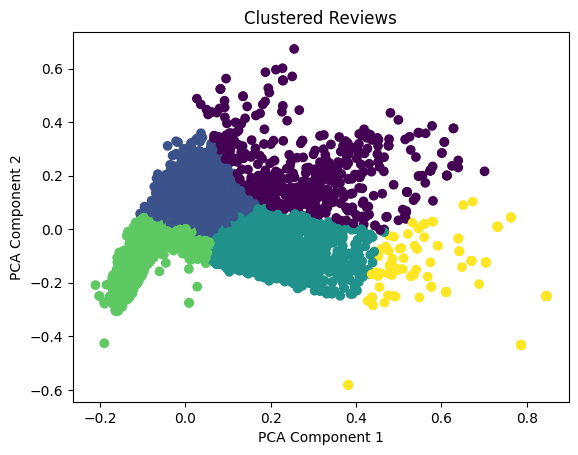

In [38]:
# Visualize the clusters (optional)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=df['cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustered Reviews')
plt.show()

# Now, you can create a mapping of cluster labels to hotel names based on your domain knowledge
cluster_mapping = {
    0: 'Hotel A',
    1: 'Hotel B',
    2: 'Hotel C',
    3: 'Hotel D',
    4: 'Hotel E'
}

# Map the cluster labels to hotel names in the DataFrame
df['hotel'] = df['cluster'].map(cluster_mapping)

# Drop temporary columns
df.drop(['review_with_rating', 'cluster'], axis=1, inplace=True)

In [39]:
df.groupby(['hotel'])['rating'].mean()

hotel
Hotel A    8.163984
Hotel B    8.043808
Hotel C    8.097141
Hotel D    7.810088
Hotel E    8.149153
Name: rating, dtype: float64

In [40]:
df.head(3)

,review,rating,hotel
63942,The car park was small and unpleasant People ...,7.1,Hotel D
63943,We weren t told that the only spa facility op...,7.1,Hotel D
63944,I asked how far the O2 was and got told a 7 m...,7.1,Hotel D


In [41]:
# Create a dictionary to store the undersampled data for each hotel
undersampled_data = {}

# List of hotel names
hotel_names = ['Hotel A', 'Hotel B', 'Hotel C', 'Hotel D', 'Hotel E']

# Loop through each hotel and undersample to 500 rows
for hotel_name in hotel_names:
    hotel_data = df[df['hotel'] == hotel_name].sample(n=200, random_state=42)  # Adjust random_state as needed
    undersampled_data[hotel_name] = hotel_data

# Concatenate the undersampled dataframes for each hotel back together
undersampled_df = pd.concat(undersampled_data.values(), ignore_index=True)

# Now undersampled_df contains the desired undersampled dataframe


In [42]:
undersampled_df

,review,rating,hotel
0,No Negative. Everything was really great Staf...,8.7,Hotel A
1,No Negative. The hotel felt safe the rooms we...,7.1,Hotel A
2,No Negative. Great location quiet room excell...,8.1,Hotel A
3,No Negative. Location helpful staff,8.1,Hotel A
4,No Negative. Great staff in all areas Lovely ...,8.1,Hotel A
...,...,...,...
995,No Negative. Breakfast very good location exc...,8.7,Hotel E
996,No Negative. Perfect,8.7,Hotel E
997,No Negative. Location,8.7,Hotel E
998,No Negative. Location,8.7,Hotel E


In [43]:
sample = undersampled_df['review'].iloc[3]
display(sample)

'No Negative.  Location helpful staff'

In [44]:
undersampled_df.to_csv("data/clean_hotel_data.csv", index=False)